In [32]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm as tqdm
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, f1_score

from modules.load_data import load_data

## EDA

In [33]:
# Load data, print its dimensions and look at first 5 rows 

# Create a data loader function
def load_data(file_name, sep=','):
    data = pd.read_csv(file_name, sep=sep)

    return data


file_name = 'data/WA_Fn-UseC_-HR-Employee-Attrition.csv'

df = load_data(file_name)
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Check the classes of the target ('Attrition' column)

df['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [4]:
# Display the column names

df.columns.tolist()

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [5]:
# Display the descriptive statistics

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


In [6]:
# Display the data types

df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [7]:
# Check NAs for all features

df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [8]:
# Check for duplicates

df.duplicated().sum()

0

In [9]:
# Print the unique values for each feature

for col in df.columns.values:
    print(f"Признак: {col}\nУникальные значения:\n{df[col].unique()}\n")

Признак: Age
Уникальные значения:
[41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]

Признак: Attrition
Уникальные значения:
['Yes' 'No']

Признак: BusinessTravel
Уникальные значения:
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Признак: DailyRate
Уникальные значения:
[1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  5

In [10]:
# Catch 'EmployeeNumber' 

df['EmployeeNumber'].nunique()

1470

* The 'EmployeeNumber' feature is just an employee sequential number, like ID and doesn't contain any useful information.   
* Also we detecting the presence of features with only one value, so such features can also be deleted.

In [11]:
# Run the loop and count the values of the columns.
# Print info for those which containing values of the same type > 0.99%.

num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.99:
        low_information_cols.append(col)
        print('{0}: {1:.3f}%'.format(col, top_pct*100))
        print(cnts, '\n')

EmployeeCount: 100.000%
1    1470
Name: EmployeeCount, dtype: int64 

Over18: 100.000%
Y    1470
Name: Over18, dtype: int64 

StandardHours: 100.000%
80    1470
Name: StandardHours, dtype: int64 



In [12]:
# delete EmployeeNumber and other non-informative features

df = df.drop(['EmployeeNumber']+low_information_cols, axis=1).copy()
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [13]:
# Change the values in the target variable to 1/0

df['Attrition'] = df['Attrition'].apply(
    lambda x: 1 if x == 'Yes' else 0).astype('int8')

In [14]:
# Save data for further visualizations

df.to_csv('data/after_EDA.csv', index=False)

In [ ]:
# Split the dataset into train and test (80/20) and save them
# Keep targets imbalance by using stratify attribute 
seed = 42

train, test = train_test_split(df, test_size=0.2, stratify=df['Attrition'], random_state=seed)
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)

---

**Summary**

* The dimensions of the original dataset are: (1470, 35);  
* The original dataset consists of numeric and categorical features;  
* There are no misses or complete duplicates in the data;  
* The original dataset has a strong imbalance of classes in the target;  
* 4 columns were removed as they has no useful information (consisted of either a single value or were IDs).   

---

## Outliers

In [34]:
file_name = 'data/after_EDA.csv'

df = load_data(file_name)
print(df.shape)
df.head()


(1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [35]:
# Split the dataset into train and test (80/20) and save them
# Keep targets imbalance by using stratify attribute 
seed = 42

train, test = train_test_split(df, test_size=0.2, stratify=df['Attrition'], random_state=seed)
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)

In [36]:
df = train

In [37]:
# Set a function to calculate the IQR boundaries

def calculate_boundaries(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    bounds = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return bounds

In [38]:
# Find the features with outliers and display information on them

numeric_cols = list(df.select_dtypes(include=np.number).columns)
numeric_data = df[numeric_cols].loc[:, df[numeric_cols].columns != 'Attrition']

for col in numeric_data:
    boundaries = calculate_boundaries(df[col])
    is_outlier = (df[col] < boundaries[0]) | (df[col] > boundaries[1])
    if is_outlier.sum() != 0:
        print(f'Выбросы для признака {col}:\n')
        print(
            f'Границы для нормальных значений с интерквартильным размахом: {boundaries}')
        print(f'Количество выбросов в признаке: {is_outlier.sum()}')
        print(
            f'Доля выбросов в признаке: {"%.2f" %(is_outlier.sum()/len(df[col])*100)}%\n\n')

Выбросы для признака MonthlyIncome:

Границы для нормальных значений с интерквартильным размахом: (-5260.75, 16629.25)
Количество выбросов в признаке: 86
Доля выбросов в признаке: 7.31%


Выбросы для признака NumCompaniesWorked:

Границы для нормальных значений с интерквартильным размахом: (-3.5, 8.5)
Количество выбросов в признаке: 36
Доля выбросов в признаке: 3.06%


Выбросы для признака PerformanceRating:

Границы для нормальных значений с интерквартильным размахом: (3.0, 3.0)
Количество выбросов в признаке: 185
Доля выбросов в признаке: 15.73%


Выбросы для признака StockOptionLevel:

Границы для нормальных значений с интерквартильным размахом: (-1.5, 2.5)
Количество выбросов в признаке: 66
Доля выбросов в признаке: 5.61%


Выбросы для признака TotalWorkingYears:

Границы для нормальных значений с интерквартильным размахом: (-7.5, 28.5)
Количество выбросов в признаке: 52
Доля выбросов в признаке: 4.42%


Выбросы для признака TrainingTimesLastYear:

Границы для нормальных значений с

In [39]:
# Replace the outliers with values close to the boundaries

for col in numeric_data:
    boundaries = calculate_boundaries(df[col])
    is_outlier_0 = df[col] < boundaries[0]
    is_outlier_1 = df[col] > boundaries[1]
    if is_outlier_0.sum() != 0:
        df.loc[is_outlier_0, col] = int(boundaries[0] + 0.5)
    if is_outlier_1.sum() != 0:
        df.loc[is_outlier_1, col] = int(boundaries[1] + 0.5)

In [18]:
# # Save data

# df.to_csv('data/preprocessed.csv', index=False)

>**Summary**

* In the YearsWithCurrManager feature, outliers are less than 1%, so we can either remove or leave them, as they do not contradict the nature of the data. In other cases, the number of outliers is large enough to remove them. Therefore, these outliers were smoothed by replacing them with values close to the IQR boundaries

* Since the task is a binary classification, I will take models that are well suited for such tasks - decision trees and boosting algorithms. Although the heat map of correlations did not show obvious strong correlations in large numbers, but at least 1 linear model should also be tested.

* Thus I chose: 'LogisticRegression', 'RandomForest', 'CatBoost', 'LightGBM'.

## Encoding

In [40]:
# Create a variable with names of the categoric features

categorical_cols = list(df.select_dtypes(include='O').columns)
categorical_cols

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [41]:
# Display the unique values for the categorical features

for col in categorical_cols:
    print(f"Признак: {col}\nУникальные значения:\n{df[col].unique()}\n")

Признак: BusinessTravel
Уникальные значения:
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Признак: Department
Уникальные значения:
['Sales' 'Research & Development' 'Human Resources']

Признак: EducationField
Уникальные значения:
['Life Sciences' 'Technical Degree' 'Marketing' 'Medical' 'Other'
 'Human Resources']

Признак: Gender
Уникальные значения:
['Female' 'Male']

Признак: JobRole
Уникальные значения:
['Manager' 'Laboratory Technician' 'Sales Representative'
 'Research Scientist' 'Manufacturing Director' 'Sales Executive'
 'Research Director' 'Healthcare Representative' 'Human Resources']

Признак: MaritalStatus
Уникальные значения:
['Divorced' 'Married' 'Single']

Признак: OverTime
Уникальные значения:
['No' 'Yes']



In [42]:
# Encode the categorical features and add them to the dataset

encoded = pd.get_dummies(df[categorical_cols], dtype='int8')
df = df.drop(categorical_cols, axis=1)
df_prepared = pd.concat([df, encoded], axis=1)
df_prepared.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
1194,47,0,1225,2,4,2,47,4,4,2,...,0,0,0,0,0,1,0,0,1,0
128,22,0,594,2,1,3,100,3,1,4,...,0,0,0,0,0,0,1,0,1,0
810,46,0,406,3,1,1,52,3,4,3,...,0,0,0,0,0,0,1,0,1,0
478,25,0,622,13,1,2,40,3,1,3,...,0,0,0,0,1,0,1,0,1,0
491,43,0,1001,9,5,4,72,3,2,3,...,0,0,0,0,0,1,0,0,0,1


In [43]:
# Display the general information

df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 1194 to 1292
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1176 non-null   int64
 1   Attrition                          1176 non-null   int64
 2   DailyRate                          1176 non-null   int64
 3   DistanceFromHome                   1176 non-null   int64
 4   Education                          1176 non-null   int64
 5   EnvironmentSatisfaction            1176 non-null   int64
 6   HourlyRate                         1176 non-null   int64
 7   JobInvolvement                     1176 non-null   int64
 8   JobLevel                           1176 non-null   int64
 9   JobSatisfaction                    1176 non-null   int64
 10  MonthlyIncome                      1176 non-null   int64
 11  MonthlyRate                        1176 non-null   int64
 12  NumCompaniesWorke

In [22]:
# Save the dataset

df_prepared.to_csv('data/df_prepered.csv', index=False)

## Modeling

In [23]:
# Load the prepered dataset

df_prepared = pd.read_csv('data/df_prepered.csv')
df_prepared

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,4,...,0,0,0,1,0,0,0,1,0,1
1,49,0,279,8,1,3,61,2,2,2,...,0,0,1,0,0,0,1,0,1,0
2,37,1,1373,2,2,4,92,2,1,3,...,0,0,0,0,0,0,0,1,0,1
3,33,0,1392,3,4,4,56,3,1,3,...,0,0,1,0,0,0,1,0,0,1
4,27,0,591,2,1,1,40,3,1,2,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,3,41,4,2,4,...,0,0,0,0,0,0,1,0,1,0
1466,39,0,613,6,1,4,42,2,3,1,...,0,0,0,0,0,0,1,0,1,0
1467,27,0,155,4,3,2,87,4,2,2,...,1,0,0,0,0,0,1,0,0,1
1468,49,0,1023,2,3,4,63,2,2,2,...,0,0,0,1,0,0,1,0,1,0


In [53]:
# Check the classes of target

df_prepared['Attrition'].value_counts()

0    986
1    190
Name: Attrition, dtype: int64

In [45]:
# Split the dataset into train and test (80/20)
# Keep targets imbalance by using stratify attribute 

X = df_prepared.drop('Attrition', axis=1)
y = df_prepared['Attrition']
seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df_prepared['Attrition'], random_state=seed)

In [46]:
# Print dimensions

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки: ", X_test.shape)

Размер обучающей выборки: (940, 51)
Размер тестовой выборки:  (236, 51)


In [48]:
# Create an instance of the StandardScaler

scaler = StandardScaler()

In [49]:
# Apply scaling to the data

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [50]:
# Create a dataset for the results

results = pd.DataFrame(data={'Model': ['LogisticRegression', 'RandomForest', 'CatBoost', 'LightGBM'],
                             'Accuracy': np.nan,
                             'Precision': np.nan,
                             'Recall': np.nan,
                             'F1': np.nan,
                             'ROC-AUC': np.nan,
                             })

results

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,LogisticRegression,NaN,NaN,NaN,NaN,NaN
1,RandomForest,NaN,NaN,NaN,NaN,NaN
2,CatBoost,NaN,NaN,NaN,NaN,NaN
3,LightGBM,NaN,NaN,NaN,NaN,NaN


In [51]:
# Set the models
models = [
    {'name': 'LogisticRegression', 'model': LogisticRegression(
        random_state=seed, class_weight='balanced', n_jobs=-1)},
    {'name': 'RandomForest', 'model': RandomForestClassifier(
        random_state=seed, class_weight='balanced', n_jobs=-1)},
    {'name': 'CatBoost', 'model': CatBoostClassifier(
        random_state=seed, auto_class_weights='Balanced', logging_level='Silent')},
    {'name': 'LightGBM', 'model': LGBMClassifier(
        random_state=seed, class_weight='balanced', n_jobs=-1, verbose=-1)}
]


# Start training the models and record the results in the dataset
for n in tqdm(models, total=len(models)):
    clf = n['model']
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = float("%.4f" % accuracy_score(y_test, y_pred))
    pres = float("%.4f" % precision_score(y_test, y_pred))
    rec = float("%.4f" % recall_score(y_test, y_pred))
    f1 = float("%.4f" % f1_score(y_test, y_pred))
    roc_auc = float("%.4f" % roc_auc_score(y_test, y_prob))

    results.loc[results['Model'] == n['name'], [
        'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']] = [acc, pres, rec, f1, roc_auc]

  0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
# Display the results sorted by accuracy

results.sort_values(by=['Accuracy'], ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,CatBoost,0.8771,0.6452,0.5263,0.5797,0.7679
1,RandomForest,0.8602,0.8571,0.1579,0.2667,0.7804
3,LightGBM,0.8602,0.5862,0.4474,0.5075,0.7718
0,LogisticRegression,0.7331,0.3494,0.7632,0.4793,0.8319


In [41]:
# Save modeling results

results.to_csv('data/modeling_results.csv', index=False)

In [33]:
# Conduct a search of the hyperparameters

# Set the searching space
space = {
        'depth': hp.uniform("depth", 4, 10),
        'iterations': hp.choice("iterations", [1000, 2000])  
       }

# Set objective function with classifier and accuracy_score maximization
def objective(space):
    clf=CatBoostClassifier(
                    depth=int(space['depth']),
                    iterations=space['iterations'],
                    auto_class_weights='Balanced',
                    logging_level='Silent',
                    random_seed=seed)
 
    
    clf.fit(X_train, y_train)
    

    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print ("SCORE:", acc)
    return {'loss': -acc, 'params': space, 'status': STATUS_OK }

In [34]:
%%time
# Start the search

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

SCORE:                                                                                                                 
0.8299319727891157                                                                                                     
SCORE:                                                                                                                 
0.8639455782312925                                                                                                     
SCORE:                                                                                                                 
0.8741496598639455                                                                                                     
SCORE:                                                                                                                 
0.8673469387755102                                                                                                     
SCORE:                                  

In [36]:
# Print the search results

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'depth': 6.108193249455739, 'iterations': 1}


In [55]:
# Train the CatBoostClassifier with new hyperparameters

cb = CatBoostClassifier(depth=6,
                        random_state=seed,
                        iterations=2000,
                        logging_level='Silent',
                        auto_class_weights='Balanced')

cb.fit(X_train, y_train)

y_pred = cb.predict(X_test)
acc = float("%.4f" % accuracy_score(y_test, y_pred))
print('Final Accuracy', acc)

Final Accuracy 0.8814


In [43]:
# Check the confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[239,   8],
       [ 26,  21]], dtype=int64)

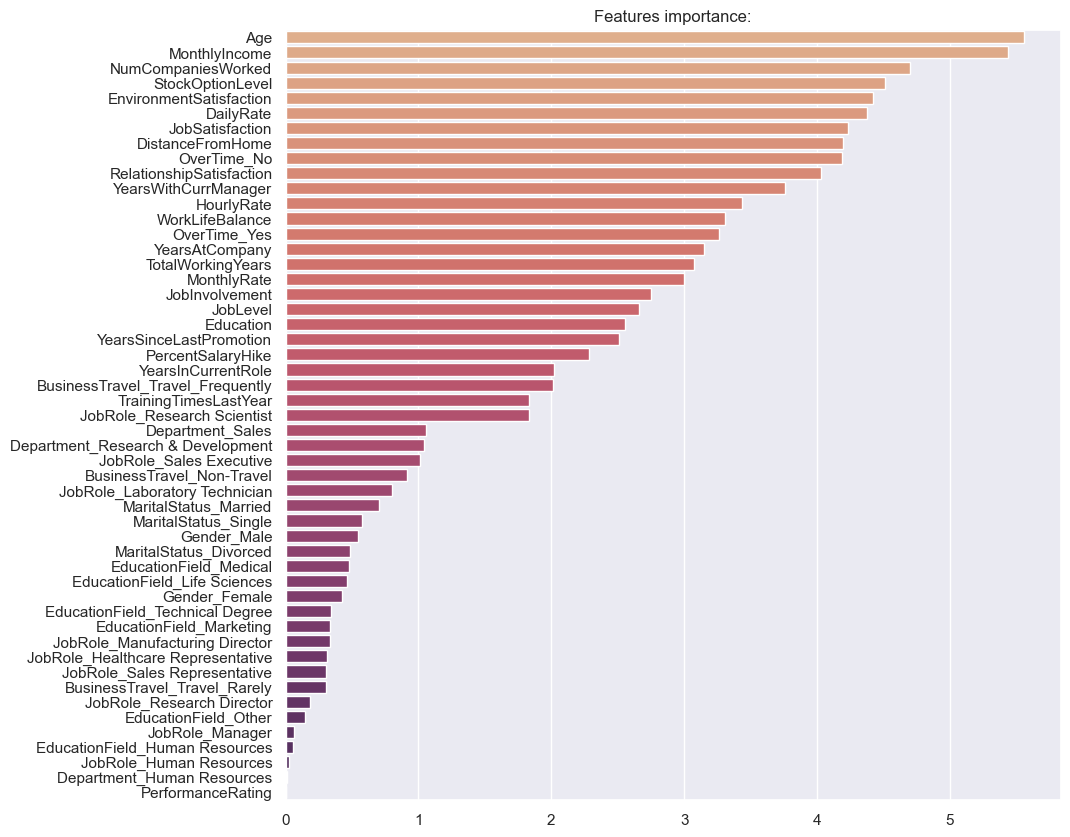

In [32]:
# Draw feature importance plot

feature_importance = cb.get_feature_importance()

# Create a dataset with sorted model weights
d = df_prepared.drop(['Attrition'], axis=1).columns

df_feature_importance = pd.DataFrame({'feature_name': d, 
                                      'feature_importance': feature_importance}).sort_values(
                                       by=['feature_importance'], ascending=False)

# Draw the plot
plt.figure(figsize=(10, 10));
sns.set();
sns.barplot(x="feature_importance", y="feature_name", data=df_feature_importance.iloc[:], palette='flare');
plt.xlabel('', );
plt.ylabel('', );
plt.title('Features importance:', );

---

>**Summary**

None of the models in the default configuration was able to reach the required 88% accuracy_score.  
* Logistic regression performed the worst, which is not surprising - there was no strong linear correlation in given data.
* Random Forest showed an average result, perhaps it is due to the small amount of data
* 2 boosting models showed themselves well, and CatBoost came close to the required metric. After hyperparameter tuning it successfully coped with the task. The final metric was 0.8844.  

CatBoost approached the task better than anything else - it is quite undemanding on machine resources, has a mode of work with GPU, doesn't require complex setting of hyperparameters.

Yes machine learning allows to create predictive models of high accuracy to predict the departure of employees from the company and in accordance with this to create the necessary reserve.